In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bapsflib import lapd
from bapsfda.processing import get_board_props, SISRun
from bapsfda.diagnostics import LangmuirSweep
from bapsfda.diagnostics._interferometer import Interferometer
from bapsfda.processing import sav_smooth, butt_low
from bapsfda.processing import sgaussian_half, expfit
from bapsfda.visualization import plot_3d_surf
from scipy.optimize import curve_fit
from astropy.constants import e, m_p
import pprint
import astropy.units as u
import os

In [2]:
data_path = "./july2023/"
file_dict = {s[:2]: s for s in os.listdir(data_path)}
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(file_dict)

{   '06': '06_xline_sweep_p20_3srep_125Vps_105Vpuff.hdf5',
    '07': '07_xline_sweep_p32_3srep_125Vps_105Vpuff.hdf5',
    '08': '08_xline_sweep_p43_3srep_125Vps_105Vpuff.hdf5',
    '09': '09_mach_cal_180_p20_3srep_125Vps_105Vpuff.hdf5',
    '10': '10_mach_cal_0_p20_3srep_125Vps_105Vpuff.hdf5',
    '11': '11_xline_mach_p20_3srep_125Vps_105Vpuff.hdf5',
    '12': '12_xline_mach_p20_3srep_125Vps_75Vpuff.hdf5',
    '13': '13_xline_sweep_p43_3srep_125Vps_75Vpuff.hdf5',
    '14': '14_xline_sweep_p32_3srep_125Vps_75Vpuff.hdf5',
    '15': '15_xline_sweep_p20_3srep_125Vps_75Vpuff.hdf5',
    '16': '16_xline_sweep_p20_3srep_125Vps_90Vpuff.hdf5',
    '17': '17_xline_sweep_p32_3srep_125Vps_90Vpuff.hdf5',
    '18': '18_xline_sweep_p43_3srep_125Vps_90Vpuff.hdf5',
    '19': '19_mach_cal_180_p20_3srep_125Vps_90Vpuff.hdf5',
    '20': '20_mach_cal_0_p20_3srep_125Vps_90Vpuff.hdf5',
    '21': '21_xline_mach_p20_3srep_125Vps_90Vpuff.hdf5',
    '22': '22_xline_Emissive_p38_3srep_125Vps_105Vpuff.hdf5',
    '23

In [3]:
run_num = "06"
run_name = f"{data_path}{file_dict[run_num]}"

In [4]:
with lapd.File(run_name) as f:
    f.run_description()

Recording Langmuir sweeps and Isat on port 20, Unlucky# 3 in x-line with 1cm point spacing x=[-30,30], 10 Shots per point.


LAPD B field:
Black magnets at south: 760 A (PS12, 13),
Yellow & Purple magnets: configured for uniform 1.5 kG
Black magnets at north: 0 A (PS11)

South LaB6 source:
He plasma , discharge PS voltage/current: 12V/7100A Control Room
84-70 V cathode-anode voltage, 1/3 Hz rep rate 
Heater: 2006A
Gas Puff (105 V on East and West, 26ms) Helium
Minimum background pressure on pfieffer box (4.5e-5, 5.6e-5)

Timing:
=====
Discharge Peried: 20 ms
Breakdown time: 6 ms
Sweep: Starting 0 ms, 96us ramp up, 28 cycles, 1ms pause
DAQ trigger: 0 ms  

Risat25= 9 Ohm  Bias: -100 V w.r.t. chamber ground 
Rsweep25= 1 Ohm 
Risat31 = 330 Ohm
Reference chamber ground

Channels:
Board 1: 
Chan8: VAnode, G=1/40
Board 3:
Chan5: (UL3-LT) VSweep, G=1/100
Chan6: (UL3-LT) ISweep, G=1.02, R=1 
Chan7: (UL3-LB) Isat, G=1.04, R=7.5
Chan8: (UL3-RT) VFloat, G=1/40


C:\Users\trloo\miniforge3\envs\test_bapsfda\Lib\site-packages\bapsflib\_hdf\maps\core.py:134: UserWarning: MSI ('MSI') does NOT exist.
  warn(f"MSI ('{msi_path}') does NOT exist.")


In [5]:
run = SISRun(run_name)
run.config_drive("fixed", run.num_shots, 1, 1, 1)
run.config_drive("xline", 10, nx = 61)
run.rename_channel("b1_c8", "V_anode")
run.rename_channel("b3_c5", "V_sweep")
run.rename_channel("b3_c6", "I_sweep")
run.rename_channel("b3_c7", "Isat")
run.rename_channel("b3_c8", "V_float")
run.set_drive_props("V_anode", "fixed")
run.set_drive_props("V_sweep", "xline")
run.set_drive_props("I_sweep", "xline")
run.set_drive_props("Isat", "xline")
run.set_drive_props("V_float", "xline")
run.set_chan_props("V_anode", gain = 1/40)
run.set_chan_props("V_sweep", gain = 1/100)
run.set_chan_props("I_sweep", gain = 1.02/np.sqrt(2), resistance=1)
run.set_chan_props("Isat", gain = 1.04, resistance = 7.5)
run.set_chan_props("V_float", gain = 1/40)

{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 64, 'bit': 16, 'nshotnum': 610, 'nt': 75776}
{'clock rate': <Quantity 100. MHz>, 'shot average (software)': None, 'sample average (hardware)': 16, 'bit': 16, 'nshotnum': 610, 'nt': 249856}


C:\Users\trloo\miniforge3\envs\test_bapsfda\Lib\site-packages\bapsflib\_hdf\maps\core.py:134: UserWarning: MSI ('MSI') does NOT exist.
  warn(f"MSI ('{msi_path}') does NOT exist.")


In [6]:
run.channel_dict

{'V_anode': SISCrateChannel(crate_index=(1, 8), board_props='board_1', channel_props=ChannelProperties(gain=0.025, resistance=None, units=Unit("V")), drive_props=DriveProperties(shots_per_pos=610, ny=1, nx=1, nz=1)),
 'V_sweep': SISCrateChannel(crate_index=(3, 5), board_props='board_3', channel_props=ChannelProperties(gain=0.01, resistance=None, units=Unit("V")), drive_props=DriveProperties(shots_per_pos=10, ny=1, nx=61, nz=1)),
 'I_sweep': SISCrateChannel(crate_index=(3, 6), board_props='board_3', channel_props=ChannelProperties(gain=0.7212489168102785, resistance=1, units=Unit("A")), drive_props=DriveProperties(shots_per_pos=10, ny=1, nx=61, nz=1)),
 'Isat': SISCrateChannel(crate_index=(3, 7), board_props='board_3', channel_props=ChannelProperties(gain=1.04, resistance=7.5, units=Unit("A")), drive_props=DriveProperties(shots_per_pos=10, ny=1, nx=61, nz=1)),
 'V_float': SISCrateChannel(crate_index=(3, 8), board_props='board_3', channel_props=ChannelProperties(gain=0.025, resistance=No

In [7]:
t_array = run.board_props["board_3"].time_array
vsweep = run.extract_signal("V_sweep")
isweep = run.extract_signal("I_sweep")
vanode = run.extract_signal("V_anode")
isat = run.extract_signal("Isat")

C:\Users\trloo\miniforge3\envs\test_bapsfda\Lib\site-packages\bapsflib\_hdf\maps\core.py:134: UserWarning: MSI ('MSI') does NOT exist.
  warn(f"MSI ('{msi_path}') does NOT exist.")
C:\Users\trloo\miniforge3\envs\test_bapsfda\Lib\site-packages\bapsflib\_hdf\maps\core.py:134: UserWarning: MSI ('MSI') does NOT exist.
  warn(f"MSI ('{msi_path}') does NOT exist.")
C:\Users\trloo\miniforge3\envs\test_bapsfda\Lib\site-packages\bapsflib\_hdf\maps\core.py:134: UserWarning: MSI ('MSI') does NOT exist.
  warn(f"MSI ('{msi_path}') does NOT exist.")
C:\Users\trloo\miniforge3\envs\test_bapsfda\Lib\site-packages\bapsflib\_hdf\maps\core.py:134: UserWarning: MSI ('MSI') does NOT exist.
  warn(f"MSI ('{msi_path}') does NOT exist.")


In [8]:
isat = np.mean(isat.reshape(61,10,249856), axis = 1)
isat = np.moveaxis(np.moveaxis(isat, 0, 1) - np.mean(isat[:,-2000:-1],axis =-1), 0, 1)
freq = (1/isat.dt).to(u.Hz).value
isat = butt_low(isat, 10e3, freq)
ismooth = sav_smooth(isat, b = 60, axis=-1)

In [9]:
sweep_args = (0 * u.ms, 100 * u.us, 1 * u.ms, .96, 28)
sweeper = LangmuirSweep(*sweep_args)

In [10]:
v_slices, i_slices, ramp_times = sweeper.slice_sweeps(isweep, vsweep, t_array)

In [11]:
r_indices = [int(a) for a in ramp_times.to(u.s).value*freq]

In [12]:
isats = np.empty((61,28))
for i in range(61):
    for j in range(28):
        isats[i,j] = ismooth[i,r_indices[j]]

In [13]:
pp = sweeper.analyze_sweeps(v_slices, i_slices)

C:\Users\trloo\pythongits\BaPSF-Research\bapsfda\processing\_fitfuncs.py:40: RuntimeWarning: overflow encountered in exp
  return abs(amp) * np.exp(-abs(t - mean) / (np.sqrt(2) * std))


In [14]:
xpos = ((np.arange(61)-30)/100)*u.m
nish = (isats*u.A)*np.sqrt(4*m_p/(pp[:,:,1]*u.eV).to(u.J))/e.si*np.exp(1/2)
nlid = np.trapz(nish, xpos, axis=0) # line integrated non-calibrated density from sweep

In [15]:
# since not inter on this run, will get the calib factor from the stored value on run 15
# t_int, smint = run15.extract_interfero()
# t_int_ramp_ind = np.arange(28)*41 + 410
# fact = smint[t_int_ramp_ind]/nlid
# a_probe_mm = ((1/fact)*u.m**2).to(u.mm**2)
# np.std(a_probe_mm[5:18]) # stdev in area during main phase
# t_int[t_int_ramp_ind]
# c = np.mean(fact[5:18])

In [16]:
with np.load("./analysisj23/run15_sweep_port20_75puff.npz") as data:
    c = data["calib"]

In [17]:
n = nish * c

In [18]:
puff = "105"
port = "20"
X = (np.arange(61)-30)
np.savez(f"./analysisj23/run{run_num}_sweep_port{port}_{puff}puff.npz", density = n, V_p = pp[:,:,0], Te = pp[:,:,1], times_ms = ramp_times.value, x_pos = X, calib = c)

In [19]:
p = n * pp[:,:,1]

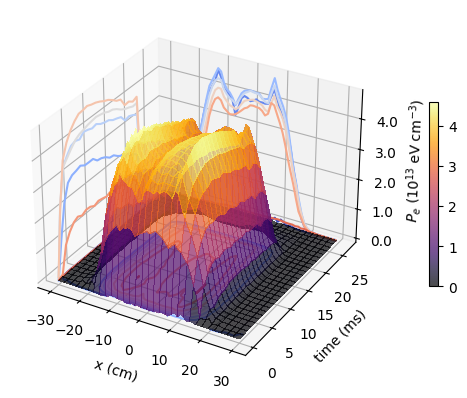

In [20]:
plt_fname = f"./analysisj23/plots/port{port}_ep_{puff}puff_125ps.pdf"
x_label = "x (cm)"
y_label = "time (ms)"
z_label = "$P_e$ ($10^{13}$ eV cm$^{-3}$)"
X = (np.arange(61)-30)
Y = ramp_times.value
Z = p.transpose().value*1e-19
plot_3d_surf(X, Y, Z, file_name = plt_fname, xlabel = x_label, ylabel = y_label, zlabel = z_label, contour = True)

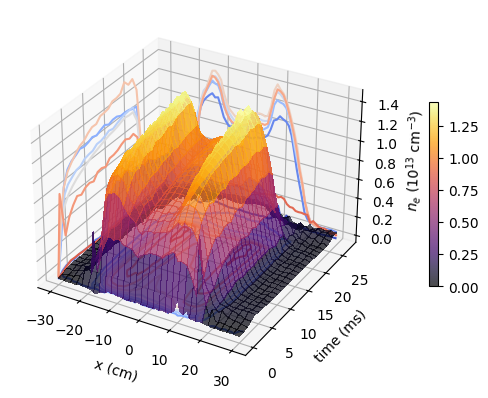

In [21]:
plt_fname = f"./analysisj23/plots/port{port}_density_{puff}puff_125ps.pdf"
x_label = "x (cm)"
y_label = "time (ms)"
z_label = "$n_e$ ($10^{13}$ cm$^{-3}$)"
X = (np.arange(61)-30)
Y = ramp_times.value
Z = n.transpose().value*1e-19
plot_3d_surf(X, Y, Z, file_name = plt_fname, xlabel = x_label, ylabel = y_label, zlabel = z_label, contour=True)

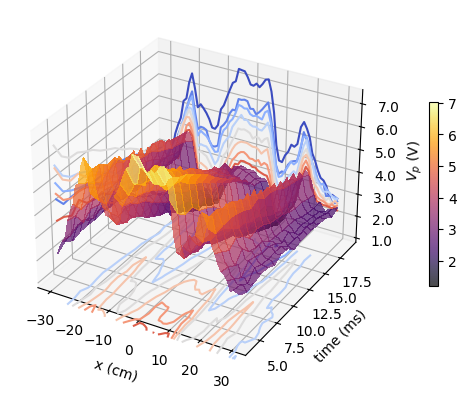

In [22]:
plt_fname = f"./analysisj23/plots/port{port}_vp_{puff}puff_125ps.pdf"
x_label = "x (cm)"
y_label = "time (ms)"
z_label = "$V_p$ (V)"
X = (np.arange(61)-30)
Y = ramp_times.value[4:20]
Z = pp[:,:,0].transpose()[4:20]
plot_3d_surf(X, Y, Z, file_name = plt_fname, xlabel = x_label, ylabel = y_label, zlabel = z_label, contour=True)

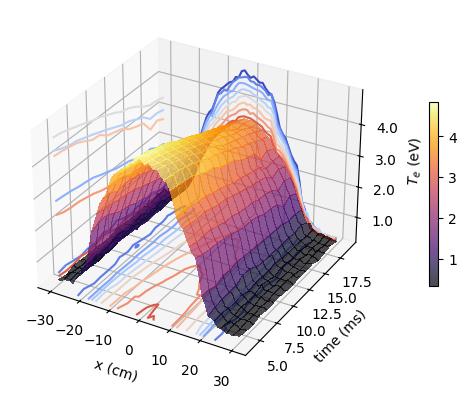

In [23]:
plt_fname = f"./analysisj23/plots/port{port}_te_{puff}puff_125ps.pdf"
x_label = "x (cm)"
y_label = "time (ms)"
z_label = "$T_e$ (eV)"
X = (np.arange(61)-30)
Y = ramp_times.value[4:20]
Z = pp[:,:,1].transpose()[4:20]
plot_3d_surf(X, Y, Z, file_name = plt_fname, xlabel = x_label, ylabel = y_label, zlabel = z_label, contour=True)

In [26]:
n[30,15]

<Quantity 1.05571009e+19 A kg(1/2) / (J(1/2) C)>

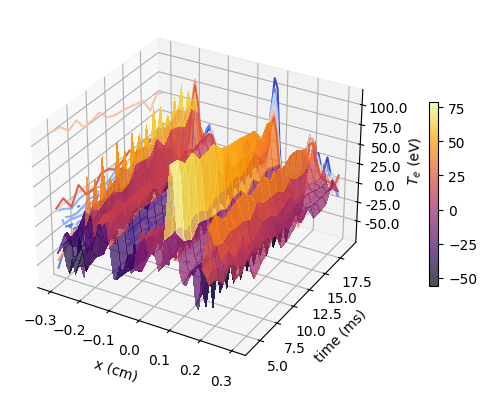

In [24]:
x_m = X/100
vp = pp[:,:,0]
E = -np.gradient(vp, x_m, axis = 0)
x_label = "x (cm)"
y_label = "time (ms)"
z_label = "$T_e$ (eV)"
plot_3d_surf(x_m, ramp_times.value[4:20], E.transpose()[4:20], xlabel = x_label, ylabel = y_label, zlabel = z_label, contour = True)

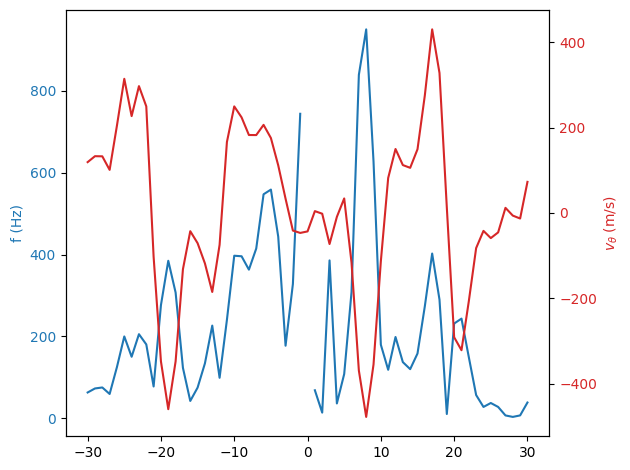

In [60]:
X = (np.arange(61)-30)
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_ylabel('f (Hz)', color=color)  # we already handled the x-label with ax1
ax1.plot(X, np.abs(vt[:,15]/x_m)/(2*np.pi), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_xlabel('x (cm)')
ax2.set_ylabel(r'$v_{\theta}$ (m/s)', color=color)
ax2.plot(X, vt[:,15], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [32]:
vt = ((-E*u.V/u.m)/(1500 * u.G).to(u.T)).to(u.m/u.s)

In [30]:
np.sqrt((1*u.eV)/(4*m_p)).to(u.m/u.s)

<Quantity 4893.5756753 m / s>

(-500.0, 500.0)

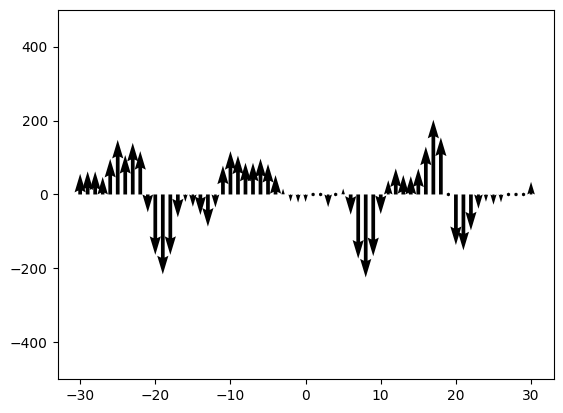

In [49]:
X = (np.arange(61)-30)
Y = [0]
X, Y = np.meshgrid(X,Y)
plt.quiver(X, Y, [0], vt[:,15].to(u.m/u.s).value)
plt.ylim(-500, 500) 

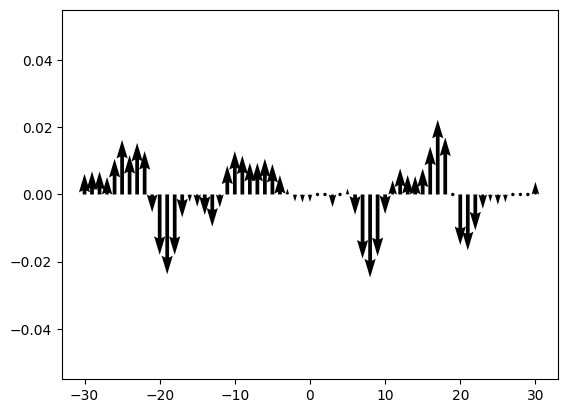